# How to use pyransac, simplest case

In [5]:
#First, some visualization functions
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pydegensac
from time import time
from copy import deepcopy

#https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html
#We will draw correspondences found and the geometric transformation between the images.
def decolorize(img):
    return  cv2.cvtColor(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)
def draw_matches(kps1, kps2, tentatives, img1, img2, H, mask):
    if H is None:
        print ("No homography found")
        return
    matchesMask = mask.ravel().tolist()
    h,w,ch = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, H)
    #print (dst)
    #Ground truth transformation
    dst_GT = cv2.perspectiveTransform(pts, H_gt)
    img2_tr = cv2.polylines(img2,[np.int32(dst)],True,(0,0,255),3, cv2.LINE_AA)
    img2_tr = cv2.polylines(deepcopy(img2_tr),[np.int32(dst_GT)],True,(0,255,0),3, cv2.LINE_AA)
    # Blue is estimated, green is ground truth homography
    draw_params = dict(matchColor = (255,255,0), # draw matches in yellow color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
    img_out = cv2.drawMatches(img1.astype(np.uint8),kps1,img2_tr.astype(np.uint8),kps2,tentatives,None,**draw_params)
    plt.figure()
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(img_out, interpolation='nearest')
    return

In [6]:
#Now helper function for running homography RANSAC
def verify_cv2(kps1, kps2, tentatives, th = 4.0 , n_iter = 2000):
    src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentatives ]).reshape(-1,2)
    dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentatives ]).reshape(-1,2)
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, th, 0.99, n_iter)
    print ('cv2 found {} inliers'.format(int(deepcopy(mask).astype(np.float32).sum())))
    return H, mask

def verify_pydegensac(kps1, kps2, tentatives, th = 4.0,  n_iter = 2000):
    src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentatives ]).reshape(-1,2)
    dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentatives ]).reshape(-1,2)
    H, mask = pydegensac.findHomography(src_pts, dst_pts, th, 0.99, n_iter)
    print ('pydegensac found {} inliers'.format(int(deepcopy(mask).astype(np.float32).sum())))
    return H, mask

In [10]:
th = 1.0
n_iter = 5000

RGB2Gray (formula)

pydegensac found 29 inliers
0.00735  sec cv2
pydegensac found 29 inliers
0.00692  sec cv2
pydegensac found 29 inliers
0.00632  sec cv2
pydegensac found 29 inliers
0.00631  sec cv2


<Figure size 432x288 with 0 Axes>

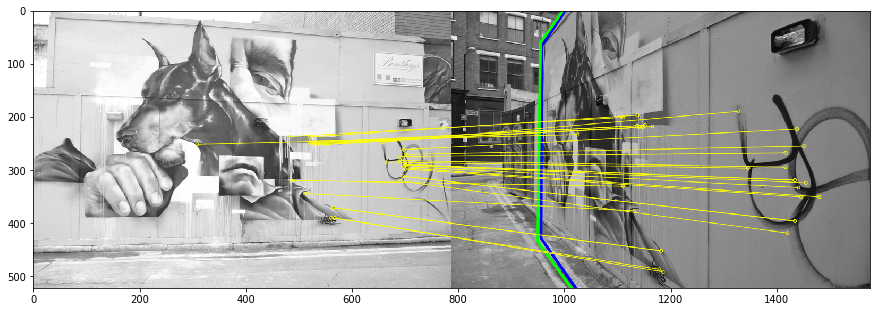

In [11]:

img1 = cv2.cvtColor(cv2.imread('img/v_dogman/1.ppm'), cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(cv2.imread('img/v_dogman/6.ppm'), cv2.COLOR_BGR2GRAY)


H_gt =np.loadtxt('img/v_dogman/H_1_6')

det = cv2.SIFT_create(8000)
kps1, descs1 = det.detectAndCompute(img1,None)
kps2, descs2 = det.detectAndCompute(img2,None)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(descs1,descs2, k=2)

# Need to draw only good matches, so create a mask
matchesMask = [False for i in range(len(matches))]

# SNN ratio test
for i,(m,n) in enumerate(matches):
    if m.distance < 0.85*n.distance:
        matchesMask[i]=True
tentatives = [m[0] for i, m in enumerate(matches) if matchesMask[i] ]

for i in range(4):
    t=time()
    cv2_H, cv2_mask = verify_pydegensac(kps1,kps2,tentatives, th, n_iter )
    print ("{0:.5f}".format(time()-t), ' sec cv2')

draw_matches(kps1, kps2, tentatives,
             cv2.cvtColor(img1,cv2.COLOR_GRAY2RGB),
             cv2.cvtColor(img2,cv2.COLOR_GRAY2RGB),
             cv2_H, cv2_mask)

Channel averaging

pydegensac found 32 inliers
0.00649  sec cv2
pydegensac found 32 inliers
0.00626  sec cv2
pydegensac found 32 inliers
0.00556  sec cv2
pydegensac found 32 inliers
0.00562  sec cv2


<Figure size 432x288 with 0 Axes>

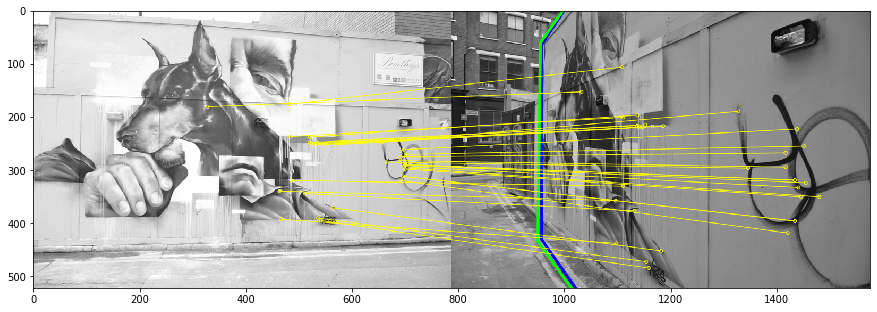

In [12]:
img1 = cv2.imread('img/v_dogman/1.ppm').astype(np.float32).mean(axis=2).astype(np.uint8)
img2 = cv2.imread('img/v_dogman/6.ppm').astype(np.float32).mean(axis=2).astype(np.uint8)


H_gt =np.loadtxt('img/v_dogman/H_1_6')

# SIFT is not available by pip install, so lets use AKAZE features
det = cv2.SIFT_create(8000)
kps1, descs1 = det.detectAndCompute(img1,None)
kps2, descs2 = det.detectAndCompute(img2,None)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(descs1,descs2, k=2)

# Need to draw only good matches, so create a mask
matchesMask = [False for i in range(len(matches))]

# SNN ratio test
for i,(m,n) in enumerate(matches):
    if m.distance < 0.85*n.distance:
        matchesMask[i]=True
tentatives = [m[0] for i, m in enumerate(matches) if matchesMask[i] ]


for i in range(4):
    t=time()
    cv2_H, cv2_mask = verify_pydegensac(kps1,kps2,tentatives, th, n_iter )
    print ("{0:.5f}".format(time()-t), ' sec cv2')


draw_matches(kps1, kps2, tentatives,
             cv2.cvtColor(img1,cv2.COLOR_GRAY2RGB),
             cv2.cvtColor(img2,cv2.COLOR_GRAY2RGB),
             cv2_H, cv2_mask)